In [5]:
import argparse
from pathlib import Path
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from tqdm import tqdm
import prolif as plf
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from pathlib import Path

In [ ]:
def prepare_complex(complex_path, box_size, ligand_name) -> tuple[plf.Molecule, list[plf.Molecule]]:
    """
    When the input is based only on the Path to complex (PDB) without sdf file with ligands.

    Parameters
    ----------
   --complex_path : Path or str
        Path or str to individual PDB file (complex of protein + ligand).
    --box_size : float
        Value in Angstroems defining protein area around ligand
    --ligand_name : str
        Name of the residue of ligand in PDB complex.

    Returns
    -------
    tuple[plf.Molecule, list[plf.Molecule]]
        Two prolif Molecule objects: selected protein and ligands from sdf file.
    """
    complex = mda.Universe(complex_path, guess_bonds=True) 
    elements = guess_types(complex.atoms.names)
    complex.add_TopologyAttr("elements", elements)
    ligand_selection = complex.select_atoms(f"resname {ligand_name}")
    if len(ligand_selection) == 0:
        raise ValueError(f"Ligand {ligand_name} is not detected in the protein.")
    protein_selection = complex.select_atoms(
        f"protein and byres around {box_size} group ligand", ligand=ligand_selection
    )
    protein_mol = plf.Molecule.from_mda(protein_selection) #Converts selected protein atoms to a prolif Molecule object.
    ligand_mol = plf.Molecule.from_mda(ligand_selection) #Converts selected ligand atoms to a prolif Molecule object.
    ligand_path = Path("ligand.sdf")
    writer = Chem.SDWriter(ligand_path)
    writer.write(ligand_mol)
    writer.close()
    lig_suppl = list(plf.sdf_supplier(ligand_path))
    return protein_mol, lig_suppl

In [ ]:
def process_multiple_pdb_files(pdb_files, box_size, ligand_name, ligand_path=None):
    results = []
    
    for pdb_file in pdb_files:
        #print(f"Processing {pdb_file}")
        try:
            protein_mol, lig_suppl = prepare_complex(complex_path= pdb_file, box_size =box_size, ligand_name =ligand_name) 

            result_df = calculate_ifp(protein_mol, lig_suppl, flag_save)
            if result_df is not None and not result_df.empty:
                result_df['PDB_File'] = pdb_file  # Add a column to identify the source PDB file
                results.append(result_df)
            else:
                print(f"No data returned for {pdb_file}")
        except Exception as e:
            print(f"Error processing {pdb_file}: {e}")
    
    if results:
        return pd.concat(results, ignore_index=True)
    else:
        print("No results to concatenate")
        return pd.DataFrame()  # Return an empty dataframe if there are no results




In [ ]:
def calculate_ifp(protein_mol, lig_suppl, flag_save: bool = True) -> pd.DataFrame:
    """
    Calculate interaction fingerprint with all bonds parameters (angle, length, DHAngel etc.)
    for two prolif objects: selected protein and ligand.

    Parameters
    ----------
   --protein_mol : plf.Molecule
        Selected area of protein for IFP calculation as prolif Molecule object.
        --lig_suppl : list[plf.Molecule]
        Ligand object for IFP calculation as prolif Molecule object.

    Returns
    -------
    Union[pd.DataFrame, None]
        pd.DataFrame with individual interaction fingerprint per one ligand with one specific residue and calculated parameters for bonds.
    """
    fp = plf.Fingerprint()
    fp.run_from_iterable(lig_suppl, protein_mol)
    df = fp.to_dataframe()
    dfs = []
    residues_list = get_aminoacids_df(df)
    for residue in residues_list:
        fp1 = fp.ifp[0][('UNL1', residue)]  # In individual IFP (interaction fingerprint), name of ligand and frame are fixed
        df = get_df_from_fp(fp1, residue)
        dfs.append(df)
    final_df = pd.concat(dfs, ignore_index=True)
    if flag_save:
        final_df.to_csv('IFP_test.csv', index=False)
    return final_df

In [8]:
pdb_files = "/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/frames/tmp_0.pdb" 
box_size = 10.0
ligand_name = "LLM"
ligand_path = None  # If you have a common ligand file, otherwise set to None

#final_results_df = process_pdb_file(pdb_files, box_size, ligand_name, ligand_path)

In [9]:
complex_path= pdb_files

In [10]:
complex = mda.Universe(complex_path, guess_bonds=True)  # read atoms and coordinates from PDB

In [11]:
complex

<Universe with 4891 atoms>

In [12]:
elements = guess_types(complex.atoms.names)


In [13]:
elements

array(['N', 'H', 'H', ..., 'H', 'H', 'H'], dtype=object)

In [14]:
len(elements)

4891

In [15]:
complex.add_TopologyAttr("elements", elements)


In [16]:
ligand_selection = complex.select_atoms(f"resname {ligand_name}")
if len(ligand_selection) == 0:
    raise ValueError(f"Ligand {ligand_name} is not detected in the protein.")
protein_selection = complex.select_atoms(
    f"protein and byres around {box_size} group ligand", ligand=ligand_selection
)
protein_mol = plf.Molecule.from_mda(protein_selection) #Converts selected protein atoms to a prolif Molecule object.
ligand_mol = plf.Molecule.from_mda(ligand_selection) #Converts selected ligand atoms to a prolif Molecule object.

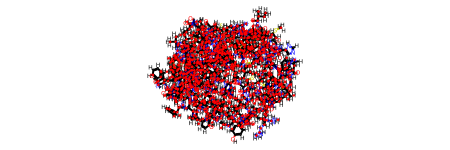

In [17]:
protein_mol

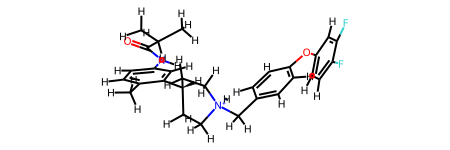

In [18]:
ligand_mol

In [19]:

ligand_path = Path("ligand.sdf")
writer = Chem.SDWriter(ligand_path)
writer

In [20]:
writer.write(ligand_mol)
writer.close()
lig_suppl = list(plf.sdf_supplier(ligand_path))


In [21]:
# final_df = calculate_ifp(protein_mol, lig_suppl, flag_save)
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, protein_mol)

  0%|          | 0/1 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x14e10ad50>

In [23]:
df = fp.to_dataframe()
df

ligand             UNL1                                                \
protein         VAL60.A    ASP61.A     PHE64.A                MET71.A   
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                   
0                  True       True        True       True        True   

ligand                                                               ...  \
protein         GLN74.A     LEU75.A     THR92.A     ASP95.A          ...   
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic HBDonor  ...   
Frame                                                                ...   
0                  True        True        True        True    True  ...   

ligand                                                               \
protein       TRP241.A                          TYR244.A              
interaction HBAcceptor PiStacking VdWContact Hydrophobic VdWContact   
Frame                                                                 
0                 True       True       True        True       True   

ligand                                                                
protein        TYR245.A    TYR273.A                         SER276.A  
interaction Hydrophobic Hydrophobic PiStacking VdWContact VdWContact  
Frame                                                                 
0                  True        True       True       True       True  

[1 rows x 30 columns]

In [24]:
dfs = []
index = pd.MultiIndex.from_tuples(df.keys(), names=['ligand', 'protein', 'interaction']) #creates a MultiIndex from the keys of the dataframe df
index

MultiIndex([('UNL1',  'VAL60.A', 'Hydrophobic'),
            ('UNL1',  'ASP61.A',  'VdWContact'),
            ('UNL1',  'PHE64.A', 'Hydrophobic'),
            ('UNL1',  'PHE64.A',  'VdWContact'),
            ('UNL1',  'MET71.A', 'Hydrophobic'),
            ('UNL1',  'GLN74.A', 'Hydrophobic'),
            ('UNL1',  'LEU75.A', 'Hydrophobic'),
            ('UNL1',  'THR92.A', 'Hydrophobic'),
            ('UNL1',  'ASP95.A', 'Hydrophobic'),
            ('UNL1',  'ASP95.A',     'HBDonor'),
            ('UNL1',  'ASP95.A',    'Cationic'),
            ('UNL1',  'ASP95.A',  'VdWContact'),
            ('UNL1',  'SER98.A',     'HBDonor'),
            ('UNL1',  'SER98.A',  'VdWContact'),
            ('UNL1',  'GLN99.A', 'Hydrophobic'),
            ('UNL1',  'GLN99.A',  'VdWContact'),
            ('UNL1', 'SER102.A',  'VdWContact'),
            ('UNL1', 'PHE237.A', 'Hydrophobic'),
            ('UNL1', 'PHE237.A',  'VdWContact'),
            ('UNL1', 'TRP241.A', 'Hydrophobic'),
            ('UNL1',

In [25]:
df2 = pd.DataFrame(df, columns=index) # new dataframe using  original dataframe df but columns indexed by the ligand, protein, and interaction levels.
df2

ligand             UNL1                                                \
protein         VAL60.A    ASP61.A     PHE64.A                MET71.A   
interaction Hydrophobic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                   
0                  True       True        True       True        True   

ligand                                                               ...  \
protein         GLN74.A     LEU75.A     THR92.A     ASP95.A          ...   
interaction Hydrophobic Hydrophobic Hydrophobic Hydrophobic HBDonor  ...   
Frame                                                                ...   
0                  True        True        True        True    True  ...   

ligand                                                               \
protein       TRP241.A                          TYR244.A              
interaction HBAcceptor PiStacking VdWContact Hydrophobic VdWContact   
Frame                                                                 
0                 True       True       True        True       True   

ligand                                                                
protein        TYR245.A    TYR273.A                         SER276.A  
interaction Hydrophobic Hydrophobic PiStacking VdWContact VdWContact  
Frame                                                                 
0                  True        True       True       True       True  

[1 rows x 30 columns]

In [59]:
aas = [col[1] for col in df2.columns] #extracts the second element (protein) from each column's tuple.
aas

['VAL60.A',
 'ASP61.A',
 'PHE64.A',
 'PHE64.A',
 'MET71.A',
 'GLN74.A',
 'LEU75.A',
 'THR92.A',
 'ASP95.A',
 'ASP95.A',
 'ASP95.A',
 'ASP95.A',
 'SER98.A',
 'SER98.A',
 'GLN99.A',
 'GLN99.A',
 'SER102.A',
 'PHE237.A',
 'PHE237.A',
 'TRP241.A',
 'TRP241.A',
 'TRP241.A',
 'TRP241.A',
 'TYR244.A',
 'TYR244.A',
 'TYR245.A',
 'TYR273.A',
 'TYR273.A',
 'TYR273.A',
 'SER276.A']

In [60]:
residues_list = aas


In [61]:
fp1 = []

In [54]:
for residue in residues_list:
        fp1 = fp.ifp[0][('UNL1', residue)]  # In individual IFP (interaction fingerprint), name of ligand and frame are fixed
        # df = get_df_from_fp(fp1, residue)
        # dfs.append(df)

fp1  

{'VdWContact': ({'indices': {'ligand': (31,), 'protein': (5,)},
   'parent_indices': {'ligand': (31,), 'protein': (2087,)},
   'distance': 2.7215632098004234},)}

In [38]:
residue = 'VAL60.A'

In [48]:
fptest = fp.ifp[0][('UNL1', residue)] 

In [49]:
fptest

{'VdWContact': ({'indices': {'ligand': (31,), 'protein': (5,)},
   'parent_indices': {'ligand': (31,), 'protein': (2087,)},
   'distance': 2.7215632098004234},)}

In [33]:
fptest.items()

dict_items([('Hydrophobic', ({'indices': {'ligand': (30,), 'protein': (6,)}, 'parent_indices': {'ligand': (30,), 'protein': (337,)}, 'distance': 4.4758210686249935},))])

In [55]:
rows = []
for interaction, details in fptest.items(): 
    for detail in details:
        row = {'interaction': interaction}
        for key, value in detail.items():
            if key not in ['indices', 'parent_indices']:  # Be careful, we are missing info about interacting indices
                row[f'{interaction}.{key}'] = value
        rows.append(row)

rows

[{'interaction': 'VdWContact', 'VdWContact.distance': 2.7215632098004234}]

In [56]:
dftest = pd.DataFrame(rows)
dftest.insert(0, 'Residue', residue)
dftest = dftest.drop(columns=['interaction'])
dftest

,Residue,VdWContact.distance
0,SER276.A,2.721563


In [57]:
residue

'SER276.A'

In [62]:
dfs = []
for residue in residues_list:
        fp1 = fp.ifp[0][('UNL1', residue)]  # In individual IFP (interaction fingerprint), name of ligand and frame are fixed
        rows = []
        for interaction, details in fp1.items(): 
                for detail in details:
                        row = {'interaction': interaction}
                        for key, value in detail.items():
                                if key not in ['indices', 'parent_indices']:  # Be careful, we are missing info about interacting indices
                                        row[f'{interaction}.{key}'] = value
                        rows.append(row)
        df1 = pd.DataFrame(rows)
        df1.insert(0, 'Residue', residue)
        df1 = df1.drop(columns=['interaction'])
        dfs.append(df1)

dfs

[   Residue  Hydrophobic.distance
 0  VAL60.A              4.475821,
    Residue  VdWContact.distance
 0  ASP61.A             3.103711,
    Residue  Hydrophobic.distance  VdWContact.distance
 0  PHE64.A               4.00642                  NaN
 1  PHE64.A                   NaN             3.348581,
    Residue  Hydrophobic.distance  VdWContact.distance
 0  PHE64.A               4.00642                  NaN
 1  PHE64.A                   NaN             3.348581,
    Residue  Hydrophobic.distance
 0  MET71.A               4.23332,
    Residue  Hydrophobic.distance
 0  GLN74.A              4.269494,
    Residue  Hydrophobic.distance
 0  LEU75.A              4.473456,
    Residue  Hydrophobic.distance
 0  THR92.A              4.377967,
    Residue  Hydrophobic.distance  HBDonor.distance  HBDonor.DHA_angle  \
 0  ASP95.A              4.498769               NaN                NaN   
 1  ASP95.A                   NaN          2.687845         165.849765   
 2  ASP95.A                   NaN 

In [63]:
final_df = pd.concat(dfs, ignore_index=True)
final_df

,Residue,Hydrophobic.distance,VdWContact.distance,HBDonor.distance,HBDonor.DHA_angle,Cationic.distance,HBAcceptor.distance,HBAcceptor.DHA_angle,PiStacking.distance,PiStacking.plane_angle,PiStacking.normal_to_centroid_angle,PiStacking.intersect_distance
0,VAL60.A,4.475821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASP61.A,NaN,3.103711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PHE64.A,4.006420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PHE64.A,NaN,3.348581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PHE64.A,4.006420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
65,TYR273.A,NaN,2.708488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,TYR273.A,3.690810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,TYR273.A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.063417,79.011757,5.49861,0.741864
68,TYR273.A,NaN,2.708488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rows = []
for interaction, details in fp1.items(): 
    for detail in details:
        row = {'interaction': interaction}
        for key, value in detail.items():
            if key not in ['indices', 'parent_indices']:  # Be careful, we are missing info about interacting indices
                row[f'{interaction}.{key}'] = value
        rows.append(row)
df1 = pd.DataFrame(rows)
df1.insert(0, 'Residue', residue)
df1 = df1.drop(columns=['interaction'])
return df1 


In [ ]:
def get_df_from_fp(fp1: dict, residue: str) -> pd.DataFrame:
    """
    Calculation of DataFrame from interaction fingerprint.

    Parameters
    ----------
    fp1 : dict
        Individual interaction fingerprint per one ligand with one specific residue.
    residue : str
        Residue name.

    Returns
    -------
    pd.DataFrame
        DataFrame with individual interaction fingerprint per one ligand with one specific residue and calculated parameters for bonds.
    """
    rows = []
    for interaction, details in fp1.items(): 
        for detail in details:
            row = {'interaction': interaction}
            for key, value in detail.items():
                if key not in ['indices', 'parent_indices']:  # Be careful, we are missing info about interacting indices
                    row[f'{interaction}.{key}'] = value
            rows.append(row)
    df1 = pd.DataFrame(rows)
    df1.insert(0, 'Residue', residue)
    df1 = df1.drop(columns=['interaction'])
    return df1 


In [ ]:
def calculate_ifp(protein_mol, lig_suppl, flag_save: bool = True) -> pd.DataFrame:
    """
    Calculate interaction fingerprint with all bonds parameters (angle, length, DHAngel etc.)
    for two prolif objects: selected protein and ligand.

    Parameters
    ----------
   --protein_mol : plf.Molecule
        Selected area of protein for IFP calculation as prolif Molecule object.
        --lig_suppl : list[plf.Molecule]
        Ligand object for IFP calculation as prolif Molecule object.

    Returns
    -------
    Union[pd.DataFrame, None]
        pd.DataFrame with individual interaction fingerprint per one ligand with one specific residue and calculated parameters for bonds.
    """
    fp = plf.Fingerprint()
    fp.run_from_iterable(lig_suppl, protein_mol)
    df = fp.to_dataframe()
    dfs = []
    residues_list = get_aminoacids_df(df)
    for residue in residues_list:
        fp1 = fp.ifp[0][('UNL1', residue)]  # In individual IFP (interaction fingerprint), name of ligand and frame are fixed
        df = get_df_from_fp(fp1, residue)
        dfs.append(df)
    final_df = pd.concat(dfs, ignore_index=True)
    if flag_save:
        final_df.to_csv('IFP_test.csv', index=False)
    return final_df